# plot_transition.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 10 April 2023

Purpose: Plot timeseries normalized by large eddy turnover time and instantaneous cross-sections of w and Rww

In [7]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn

Settings

In [8]:
# location of netCDF simulation output
output = "/home/rfrost/simulations/nc/"
# name of simulation
sim = "full_step_9"
# ug of simulation in m/s
ug = 9
# heights being analyzed
heights = np.array([0.25])
# timesteps
t0 = 576000
t1 = 1152000
dnc = f"{output}{sim}/"
# start/end times in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600
# flag to normalize time by TL
norm_time = False

### Read in data

In [9]:
# volumetric stats
stats = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
# find which timestep t0 occurs
jt = abs(stats.time.values - 0).argmin()
# calculate large eddy turnover time
TL = stats.zi.isel(time=jt) / stats.wstar.isel(time=jt)
TL = TL / 3600
# convert time to hours
stats["time"] = stats.time / 3600 + t0hr
# stats = stats.where(stats.time >= 8, drop=True)
# stats = stats.where(stats.time <= 15, drop=True)
# center time around forcing change
stats["time"] = stats.time# - 10

# roll factor
R = []
h = heights * 100
h = h.astype(int)
for i in h:
    r = xr.load_dataarray(f"{dnc}rollfactor_zzi{i}_raw.nc")
    R.append(r)
# convert time to hours and center around surface forcing change
for i, r in enumerate(R):
    r["time"] = (r.time) / 3600 + t0hr# - 10

# autocorrelation
R2d = xr.open_dataset(f"{dnc}R_2d.nc")
# convert time to hours and center around surface forcing change
R2d["time"] = R2d.time / 3600 + t0hr# - 10

# length scales
# length = xr.open_dataset(f"{dnc}")

# normalize time by TL if desired
if norm_time:
    # stats
    stats["time"] = stats.time / TL
    # roll factor
    for i, r in enumerate(R):
        r["time"] = r.time / TL
    # 2d autocorr
    R2d["time"] = R2d.time / TL

### Timeseries plots

In [10]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap = seaborn.color_palette("Spectral", as_cmap=True)
colors = seaborn.color_palette("rocket_r", len(heights))

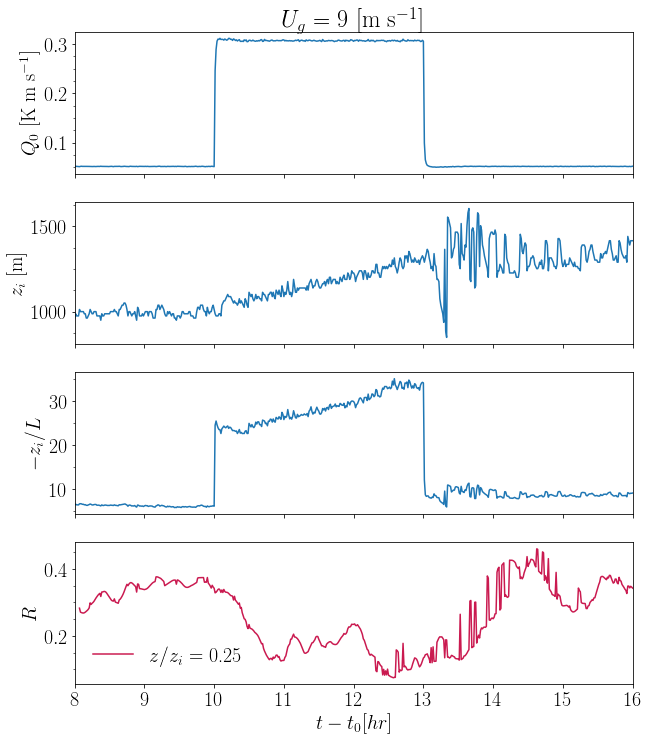

In [11]:
fig, ax = plt.subplots(figsize=(10,12), nrows=4, sharex=True)

# Q0
ax[0].plot(stats.time, stats.tw_cov_tot.isel(z=0))
# zi
ax[1].plot(stats.time, stats.zi)
# -zi/L
ax[2].plot(stats.time, stats.zi_L)
for i, r in enumerate(R):
    # R
    ax[3].plot(r.time, r, c=colors[i], label=f"$z/z_i$ = {heights[i]}")

# clean up
ax[0].set_ylabel("$Q_0$ [K m s$^{-1}$]")
ax[1].set_ylabel("$z_i$ [m]")
ax[2].set_ylabel("$-z_i / L$")
ax[3].set_ylabel("$R$")
ax[3].set_xlabel("$t - t_0 [hr]$")
ax[3].legend(frameon=False)
ax[3].set_xlim(8,16)

# add vertical line at t0
for iax in ax:
    iax.axvline(x=0, ls="--", c="black", alpha=0.5, lw=1.25)
    # minor ticks on x axis
    iax.xaxis.set_minor_locator(MultipleLocator(1))

# add minor ticks to y axis
ax[0].yaxis.set_minor_locator(MultipleLocator(0.025))
ax[1].yaxis.set_minor_locator(MultipleLocator(125))
ax[2].yaxis.set_minor_locator(MultipleLocator(5))
ax[3].yaxis.set_minor_locator(MultipleLocator(0.05))

fig.tight_layout
ax[0].set_title(f"$U_g$ = {ug} [m s$^{{-1}}$]")
plt.show()
plt.close()

Roll factor

Text(0.5, 0, '$(t - t_0) / T_L$')

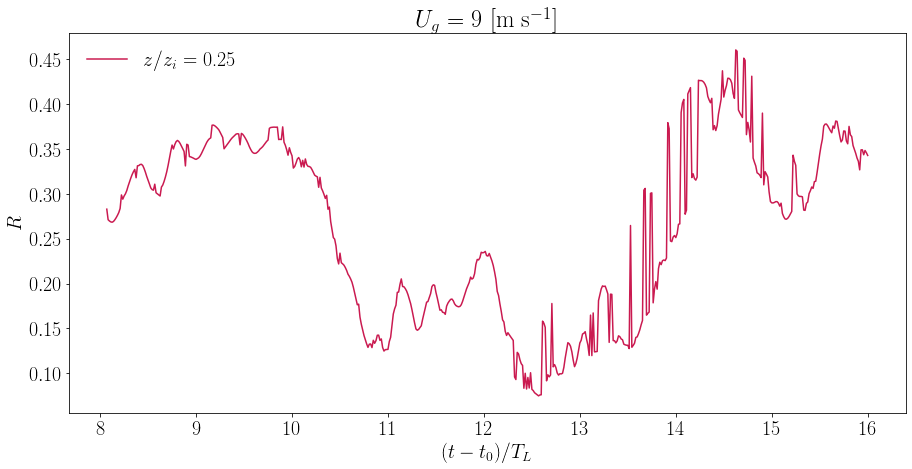

In [12]:
fig, ax = plt.subplots(figsize=(15,7))

for i, r in enumerate(R):
    # R
    ax.plot(r.time, r, c=colors[i], label=f"$z/z_i$ = {heights[i]}")

# ax.set_xlim(-2,5)
ax.legend(frameon=False)
ax.set_title("$U_g$ = 9 [m s$^{-1}$]")
ax.set_ylabel("$R$")
ax.set_xlabel("$(t - t_0) / T_L$")